Initial Data Shape: (142704, 14)
Shape after preprocessing: (142653, 17)


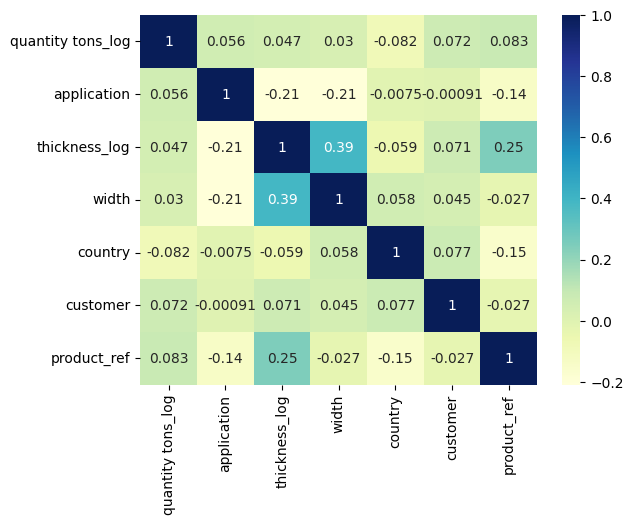

Decision Tree Regressor
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean Squared Error: 0.23556116949969008
R-Squared: 0.3622115200154673
Classifier Accuracy: 0.910952239942468
Confusion Matrix:
[[ 4096  1100]
 [ 1005 17438]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      5196
           1       0.94      0.95      0.94     18443

    accuracy                           0.91     23639
   macro avg       0.87      0.87      0.87     23639
weighted avg       0.91      0.91      0.91     23639



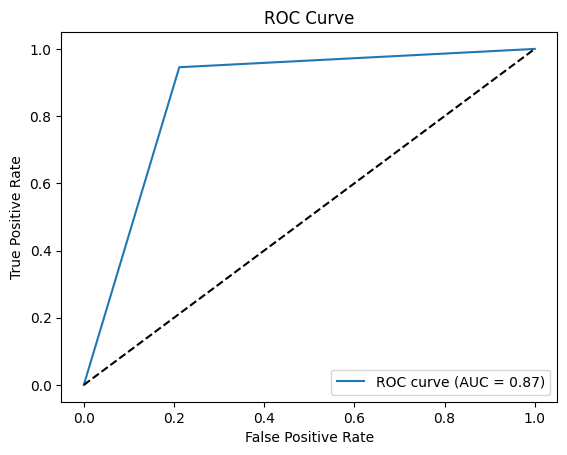

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
import pickle

# Load Dataset
def load_dataset(file_path):
    df = pd.read_csv(r"Copper_Set.xlsx - Result 1.csv")
    return df

# Preprocessing
def preprocess_data(df):
    df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
    df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
    df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
    df['country'] = pd.to_numeric(df['country'], errors='coerce')
    df['application'] = pd.to_numeric(df['application'], errors='coerce')
    df['thickness'] = pd.to_numeric(df['thickness'], errors='coerce')
    df['width'] = pd.to_numeric(df['width'], errors='coerce')
    df['material_ref'] = df['material_ref'].str.lstrip('0')
    df['product_ref'] = pd.to_numeric(df['product_ref'], errors='coerce')
    df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
    df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

    # Handle missing values
    df['material_ref'].fillna('unknown', inplace=True)
    df.dropna(inplace=True)

    # Log transformation
    for col in ['selling_price', 'quantity tons', 'thickness']:
        df[f'{col}_log'] = np.log(df[col].replace({0: np.nan}).dropna())

    df.dropna(inplace=True)
    return df

# Plot Correlation Heatmap
def plot_correlation(df, features):
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, cmap="YlGnBu")
    plt.show()

# Train Regressor
def train_regressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    param_grid = {
        'max_depth': [2, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dtr = DecisionTreeRegressor()
    grid_search = GridSearchCV(dtr, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Decision Tree Regressor")
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Mean Squared Error:", mse)
    print("R-Squared:", r2)

    return best_model

# Train Classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Classifier Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return dtc

# Save Model
def save_model(model, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

# Load Model
def load_model(file_name):
    with open(file_name, 'rb') as file:
        return pickle.load(file)

# Main Workflow
file_path = r"C:\Users\91939\OneDrive\Desktop\Copper_P4\DATASET\INDUSTRY_COPPER.csv"
df = load_dataset(file_path)
print("Initial Data Shape:", df.shape)

df = preprocess_data(df)
print("Shape after preprocessing:", df.shape)

# Regression Workflow
reg_features = ['quantity tons_log', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']
plot_correlation(df, reg_features)
X_reg = df[reg_features]
y_reg = df['selling_price_log']
regressor_model = train_regressor(X_reg, y_reg)
save_model(regressor_model, 'regressor_model.pkl')

# Classification Workflow
df_c = df[df['status'].isin(['Won', 'Lost'])]
clf_features = ['quantity tons_log', 'selling_price_log', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']
X_clf = df_c[clf_features]
y_clf = LabelBinarizer().fit_transform(df_c['status'])
classifier_model = train_classifier(X_clf, y_clf)
save_model(classifier_model, 'classifier_model.pkl')
